In [2]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as sig
from math import sqrt
import scipy.stats as stats
import scipy.interpolate as interpolate
import soundfile as sf
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
from IPython.display import display, Audio

In [3]:
def truncated_cauchy_rvs(loc=0, scale=2, a=-10, b=10, size=None):
    """
    Generate random samples from a truncated Cauchy distribution.

    `loc` and `scale` are the location and scale parameters of the distribution.
    `a` and `b` define the interval [a, b] to which the distribution is to be
    limited.

    With the default values of the parameters, the samples are generated
    from the standard Cauchy distribution limited to the interval [-1, 1].
    """
    ua = np.arctan((a - loc)/scale)/np.pi + 0.5
    ub = np.arctan((b - loc)/scale)/np.pi + 0.5
    U = np.random.uniform(ua, ub, size=size)
    rvs =  loc + scale * np.tan(np.pi*(U - 0.5))
    return rvs

In [4]:
def get_truncated_normal(mean=0, sd=4, low=0, upp=10):
    return stats.truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def get_truncated_uniform(low=-10, upp=20):
    return stats.uniform(
        loc=low, scale=upp)

0.007419906391278743


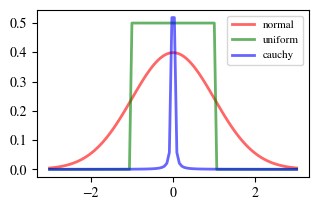

In [98]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

L = -10
H = 10
t = np.linspace(-3, 3, 100)
uniform_t = np.linspace(stats.uniform.ppf(0.001, L, H), stats.uniform.ppf(0.999, L, H), 100)
poisson_t = np.arange(-3, 4)
bernoulli_t = np.arange(-3,4)
# norm = get_truncated_normal(mean=0, sd=1/3.09, low=L, upp=H)
# uniform = get_truncated_uniform(low=L, upp=2*H)

norm = stats.norm()
uniform = stats.uniform(loc=-1, scale=2)
cauchy = stats.cauchy(0, 0.0015)
logistic = stats.logistic(loc=0, scale=0.13)
poisson = stats.poisson(0.13, loc=-1)
poisson_interp = interpolate.interp1d(poisson_t, poisson.pmf(poisson_t)) # since poisson is discrete, for visualization
# drunk = [0, 0, 0.5, 0, 0.5, 0, 0]

# x= boundaryFunc.rvs(size=1000)
plt.plot(t, norm.pdf(t), 'r', lw=2, alpha=0.6, label='normal')
plt.plot(t, uniform.pdf(t), 'g', lw=2, alpha=0.6, label='uniform')
plt.plot(t, cauchy.pdf(t), 'b', lw=2, alpha=0.6, label='cauchy')
# plt.plot(t, poisson_interp(t), 'c', lw=2, alpha=0.6, label='poisson')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('density_funcs.pdf')

In [5]:
def brownian(x0, n, dt, delta, out=None):
    x0 = np.asarray(x0)
    x_cur = 0
    r = stats.norm.rvs(size=x0.shape + (n,), scale = delta*sqrt(dt))

    if out is None:
        out = np.empty(r.shape)

    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)

    return out

In [100]:
# random walk functions

def random_walk_boundary(steps: int, limit: int, stepSize=1, probability_dist="drunk"):
    y = []
    x_cur = 0
    step_size = stepSize

    if probability_dist == "drunk":
        for _ in range(steps):
            # check if we hit a barrier
            if np.abs(x_cur) + step_size > limit:
                step = np.sign(x_cur) * (-1 * step_size)
            else:
                step = np.random.choice([step_size, -1*step_size])
            x_cur += step
            y.append(step)

    else:
        if probability_dist == "uniform":
            randFunc = stats.uniform(-10, 20)
            boundaryFunc = stats.uniform(0, 10)

        elif probability_dist == "normal":
            randFunc = stats.norm(0, 1/3.09) # randFunc.interval(0.999) between [-1.0, 1.0]
            boundaryFunc = stats.norm(0, 1/3.09)
            
        elif probability_dist == "logistic":
            randFunc = stats.logistic(loc=0, scale=0.13) # randFunc.interval(0.999) between [-1.0, 1.0]
            boundaryFunc = stats.logistic(loc=0, scale=0.13)
            
        elif probability_dist == "poisson":
            randFunc = stats.poisson(0.13, loc=-1) # randFunc.interval(0.999) between [-1.0, 1.0]
            boundaryFunc = stats.poisson(2)

        for _ in range(steps):
          # check if we hit a barrier
            if np.abs(x_cur) + step_size > limit: 
                if probability_dist == "cauchy":
                    step = np.sign(x_cur) * (-1 * step_size * np.abs(truncated_cauchy_rvs())/10) # make sure to reflect across boundary
                else:
                    step = np.sign(x_cur) * (-1 * step_size * np.abs(boundaryFunc.rvs())/10) # make sure to reflect across boundary
            else:
                if probability_dist == "cauchy":
                    step = truncated_cauchy_rvs()/10 
                else:
                    step = randFunc.rvs()/10
            x_cur += step
            y.append(step)

    x = np.cumsum(y) # compute walk
    return x

def second_order_random_walk(steps: int, limit: int, stepSize=1, probability_dist="drunk"):
    # start at 0
    xs = [0]
    if probability_dist == "brownian":
        dt = 1
        ys = np.empty((1, steps+1))
        ys[:, 0] = 0
        ys = brownian(ys[:, 0], steps, dt, 2, out=ys[:, 1:])
        ys = ys[0]
    else:
        ys = random_walk_boundary(steps, limit, stepSize, probability_dist)
    for y in ys:
        next_step = xs[-1] + y
        if np.abs(next_step) > limit:
            # print(next_step)
            # invert the movement of the step if we would exceed the barrier
            next_step = xs[-1] + -1 * y
        xs.append(next_step)
    return np.array(xs), ys

In [101]:
class DSWS:
    """Class implementing the Dynamic Stochastic Wavetable Synthesis 
    algorithm (Radna, 2023) with further extensions and spectral analysis abilities.
    
    ------------
    Attributes:
    fs : int
        sample rate of the output audio, in Hz
    frequency : float
        fundamental frequency of the output audio, in Hz
    sampLength : int
        duration of the output audio in samples
    midiFreq : float
        frequency attribute converted to a MIDI note value with interpolation. simplifies 
        symmetric pitch deviation behavior due to logarithmic scaling
    sampLength : int
        total number of samples in the output audio 
    numSegs : int
        number of segments into which the wavetable is divided
    tableLength : int
        length of the wavetable, in samples
    wavetable : np.array
        wavetable to be read from during audio generation
    output : np.array
        the output buffer to be returned at the end of audio generation
    waveform : str
        type of waveform to use for the base wavetable. options are: 
        sine, BLSaw (band-limited saw), BLSquare (band-limited square),
        BLTri (band-limited triangle), random (second-order drunk walk),
        noise (white noise)
    probDistribution : str
        type of probability distribution to be used for random walk
        generation. options: drunk, uniform, normal, logistic, poisson,
        cauchy 
    phi : float
        phase accumulator for table lookup intervals
    pitchStepBound : float
        the outer limit of the random walk generation (at +-pitchStepBound), in semitones
    pitchStepSize : float
        the step size of the random walk generation, in semitones
    walkOrder : int
        specifies whether to use first-order or second-order random walks in generation.     
    """
    def __init__(self, fs=44100, frequency=100, length=3, waveFunc="sine", 
                 waveSegments=8, pitchStepSize=1, pitchStepBound=12, pitchDepth=1,
                 maxAmpDev=0.5, isSingleSegment=True, isConstantDev=False, 
                 devMode="stochastic", probDistribution="drunk", walkOrder=2, oversample=1):
        
        self.oversample = oversample
        self.fs = fs 
        self.frequency = frequency
        self.midiFreq = 12 * np.log(self.frequency/220)/np.log(2) + 57
        self.sampLength = int(length * self.fs * self.oversample)
        self.numSegs = waveSegments
        self.isSingleSegment = isSingleSegment
        self.tableLength = 1000
        self.wavetable = np.zeros((self.tableLength, ))
        self.output = np.zeros((self.sampLength,))
        
        validWaveFuncs = {"sine", "BLSaw", "BLSquare", "BLTri", "random", "noise"}
        if waveFunc not in validWaveFuncs:
            raise ValueError("__init__: waveFunc must be one of %r." % validWaveFuncs)
        self.waveform = waveFunc # not sure this is how i wanna do this
        
        validProbDists = {"drunk", "uniform", "normal", "logistic", "poisson", "cauchy"}
        if probDistribution not in validProbDists:
            raise ValueError("__init__: probDistribution must be one of %r." % validProbDists)
        self.probDistribution = probDistribution
        
        self.phi = self.frequency * self.tableLength / (self.fs * self.oversample)
        
        self.pitchStepBound = pitchStepBound
        self.pitchStepSize = pitchStepSize
        self.pitchDepth = pitchDepth
        self.maxAmpDev = maxAmpDev
        self.walkOrder = walkOrder
        self.devMode = devMode
    
        
    def genWaveTable(self):
        validWaveFuncs = {
            "sine":self.genSine, 
            "BLSaw":self.genBLSaw,
            "BLSquare":self.genBLSquare, 
            "BLTri":self.genBLTri,
            "random":second_order_random_walk,
            "noise":np.random
        }

        if self.waveform == "random": # can also create second order random walk as wavetable
            self.wavetable, _ = validWaveFuncs[self.waveform](self.tableLength, limit=1000)
            self.wavetable = self.wavetable/np.max(np.abs(self.wavetable))

        else: 
            self.wavetable = validWaveFuncs[self.waveform](self.tableLength, self.frequency, (self.fs* self.oversample))

        return self.wavetable
    
    def genDevArray(self, length, barrier, stepSize, probDistribution, order):
        walkDict = {
            1: [],
            2: []
        }
        walkDict[2], walkDict[1] = second_order_random_walk(length, limit=barrier, 
                                                            stepSize=stepSize, probability_dist=probDistribution)
        
        return walkDict[order]

    
    def genAudio(self):
        wavetable = self.genWaveTable()
        devTable = wavetable.copy()
        n = 0
        a = 0
        mu = 0
        segIndex = 0
        segCount = 0 
        deviationIndex = segCount * self.numSegs + segIndex
        pitchDevLen = self.sampLength * self.numSegs
        
        # deviation array generation of maximum possible length (for ease of implementation)
        if self.devMode == "lfo":
            pitchDevArray = np.zeros(pitchDevLen)
            for idx in range(pitchDevLen):
                pitchDevArray[idx] = self.pitchStepBound * np.sin(2.0 * np.pi * 500.0 * idx / self.sampLength)
        else: 
            pitchDevArray = self.genDevArray(self.sampLength * self.numSegs, self.pitchStepBound, self.pitchStepSize, self.probDistribution, self.walkOrder)
            
        ampDevArray = self.genDevArray(self.numSegs, 1000, 1, self.probDistribution, 1)
        ampDevArray = ampDevArray/np.max(np.abs(ampDevArray))
        
        for outIndex in range(self.sampLength):
            self.output[outIndex] = self.lerp(wavetable, n)
            n += self.phi
            
            # counts total number of segments progressed, streamlines single segment processing
            deviationIndex = segCount * self.numSegs + segIndex
            
            if n > self.tableLength:
                if self.isSingleSegment:
                    self.phi = (440 * np.power(2, (self.midiFreq + 1 * self.pitchDepth * pitchDevArray[segCount] - 69)/12)) * self.tableLength / (self.fs * self.oversample)
                ampDevArray = self.genDevArray(self.numSegs, 1000, 1, self.probDistribution, 1)
                ampDevArray = ampDevArray/np.max(np.abs(ampDevArray))
                segCount += 1
            n %= self.tableLength
            
            k = segIndex+1 if segIndex < self.numSegs - 1 else 0
            mu = (self.numSegs * (n/self.tableLength)) - segIndex
            mu = np.abs(mu) if np.abs(mu) <= 1 else 1.0
            
            a = (1 - mu) * self.maxAmpDev * ampDevArray[segIndex] + mu * self.maxAmpDev * ampDevArray[k]
            
            # wavefolding piecewise function
            if self.output[outIndex] + a > 1:
                self.output[outIndex] = 1 - (np.abs(self.output[outIndex] + a) - 1)
            elif self.output[outIndex] + a < -1:
                self.output[outIndex] = -1 + (np.abs(self.output[outIndex] + a) - 1)
            elif -1 <= self.output[outIndex] + a and self.output[outIndex] + a <= 1:
                self.output[outIndex] += a
            
            # update current segment index (m)
            segIndex = np.floor(self.numSegs * n/self.tableLength).astype(int)
            if not self.isSingleSegment:
                self.phi = (440 * np.power(2, (self.midiFreq + 1 * self.pitchDepth * pitchDevArray[deviationIndex] - 69)/12)) * self.tableLength / (self.fs * self.oversample)
            
        self.fade()
        if self.oversample != 1:
            b,a = sig.butter(12, self.fs/2, fs=(self.fs * self.oversample))
            self.output = sig.lfilter(b, a, self.output)
        self.output = self.output[::self.oversample]
        # sos = sig.butter(8, self.fs/2, 'low', fs=self.fs*self.oversample, output='sos')
        # self.output = sig.sosfilt(sos, self.output)
        # self.output = self.output[:-self.oversample:self.oversample]
        # self.output = sig.decimate(self.output, self.oversample, ftype='iir')
        self.sampLength = int(self.sampLength/self.oversample)
        return self.output
    

    def genSine(self, length, freq, fs):
        output = np.zeros(length)
        for n in range(length):
            output[n] = np.sin(2 * np.pi * n / length)
        return output
    
    def genBLSquare(self, length, freq, fs):
        output = np.zeros(length)
        k = 1
        f = 1
        freqReal = freq
        t = np.arange(0, length) / length
        while k * freqReal < fs/2:
            output += 4/np.pi * 1/k * np.sin(2 * np.pi * f * k * t)
            k += 2
        output = output / np.max(np.abs(output))
        return output
    

    def genBLSaw(self, length, freq, fs):
        output = np.zeros(length)
        k = 1
        f = 1
        freqReal = freq
        t = np.arange(0, length) / length
        while k * freqReal < fs/2:
            output += -2/np.pi * 1/k * np.sin(2 * np.pi * f * k * t)
            k += 1
        return output
    

    def genBLTri(self, length, freq, fs):
        output = np.zeros(length)
        k = 1
        f = 1
        freqReal = freq
        t = np.arange(0, length) / length
        while k * freqReal < fs/2:
            output += 8/(np.pi**2) * ((-1)**((k-1)/2))/(k**2) * np.sin(2 * np.pi * f * k * t)
            k += 2
        return output
    
    def lerp(self, wavetable, index): # simple lerp
        truncated_index = int(np.floor(index))
        next_index = (truncated_index + 1) % wavetable.shape[0] # gets next index circularly

        next_index_weight = index - truncated_index
        truncated_index_weight = 1 - next_index_weight

        return truncated_index_weight * wavetable[truncated_index] + next_index_weight * wavetable[next_index]

    def fade(self, fade_length=1000):
        fade_in = (1 - np.cos(np.linspace(0, np.pi, fade_length))) * 0.5 # creates nice cosine fade window
        fade_out = np.flip(fade_in)

        self.output[:fade_length] = np.multiply(fade_in, self.output[:fade_length])
        self.output[-fade_length:] = np.multiply(fade_out, self.output[-fade_length:])
    
    
    def plotInfo(self):
        freqs = np.fft.fftfreq(self.sampLength, d=1/self.fs)
        print(freqs.shape)

        fig, ax = plt.subplots(1,3)
        ax[0].set_title("Sample of output waveform")

        ##plot section of waveform
        ax[0].plot(self.output[-4000:-3000])

        ## plot spectrogram
        S = np.abs(librosa.stft(self.output))
        img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=self.fs, y_axis='log', x_axis='time', ax=ax[1], vmin=-100)
        ax[1].set_title('Power spectrogram')
        fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
        fig.set_figwidth(13)
        fig.tight_layout()

        ## plot magnitude spectrum
        ax[2].plot(freqs, 20 * np.log10(np.abs(np.fft.fft(self.output)/(self.fs/2))))
        plt.xlim([0,self.fs/2])
        plt.ylim([-80,0])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        plt.title('Magnitude spectrum')

In [105]:
# simple FM implementation

def freqMod(modFreq, carrierFreq, carrierAmp=1, modAmp=1, duration=1, \
            sr=44100, modIndex=1, beta="static"):
    A_c = 1
    A_m = 1

    f_m = modFreq
    f_c = carrierFreq
    phase = -np.pi/2 # cos phase shift
    t = np.linspace(0, duration, int(duration*fs), endpoint=False)

    omega_c = 2 * np.pi * f_c * t
    omega_m = 2 * np.pi * f_m * t

    if beta == "static":
        B = 1
    elif beta == "linear":
        B = np.linspace(0, 1., int(duration*fs), endpoint=False)

    modulator = np.sin(omega_m) * modIndex
    carrier = np.sin(omega_c)

    freqModulation = A_c * np.sin(omega_c + phase + modIndex * B * np.sin(omega_m + phase))

    return freqModulation

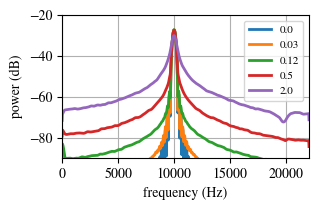

In [140]:
""" 
Figure 2 (Boyko & Canfield-Dafilou, 2024)
PSD for DSWS using a 10 kHz sinusoidal wavetable
and stochastic pitch deviations according to a Bernoulli 
probability distribution and variable pitch deviation amount
"""

fs = 44100
frequency = 10000

pitchDeviations = np.concatenate(([0], 2.0**np.arange(-5, 3, 2)))

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for pd in pitchDeviations:
    testing = DSWS(waveFunc="sine", length=3, frequency=frequency,
                   pitchStepBound=1, pitchStepSize=1, maxAmpDev=0.,
                   walkOrder=2, waveSegments=4, isSingleSegment=False,
                   probDistribution="drunk", pitchDepth=pd)
    x = testing.genAudio()

    bal_x = x - np.mean(x)

    f, p = sig.welch(bal_x, fs, nfft=2048)
    plt.plot(f,10*np.log10(p), linewidth=2, label=np.round(pd, 2))

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('pitch deviation (fixed)')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('NEW_pd_f' + str(frequency) + '.pdf')

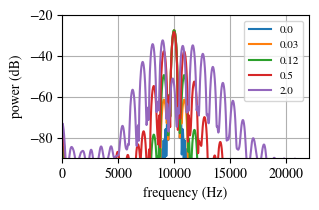

In [136]:
""" 
Figure 3 (Boyko & Canfield-Dafilou, 2024)
PSD for DSWS using a 10 kHz sinusoidal wavetable
and pitch deviations set through sinusoidal modulation with a 
frequency of 500 Hz and variable pitch deviation amount
"""

# plot PSD of as a function of mod index of constant (sinusoidal) pitch deviations, sine wavetable

pitchDeviations = np.concatenate(([0], 2.0**np.arange(-5, 3, 2)))
frequency = 10000
fs=44100

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for pd in pitchDeviations:
    testing = DSWS(waveFunc="sine", length=0.5, frequency=frequency,
                   pitchStepBound=2, pitchStepSize=1, maxAmpDev=0.,
                   walkOrder=2, waveSegments=4, isSingleSegment=False,
                   probDistribution="drunk", pitchDepth=pd, devMode="lfo")
    x = testing.genAudio()
    f, p = sig.welch(x, fs, nfft=2048)
    sf.write(f'Audio/fig3/sine_lfo_pitchdev_f{frequency}_{pd}.wav', x, fs)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label=np.round(pd, 2))

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('NEW_lfo_f' + str(frequency) + '.pdf')

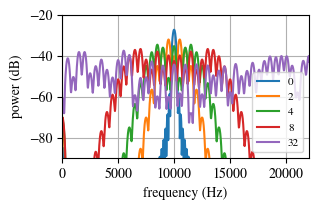

In [106]:
""" 
Figure 4 (Boyko & Canfield-Dafilou, 2024)
PSD for FM synthesis with a carrier frequency of
10 kHz, modulation frequency of 500 Hz, and modulation index
(controlling the bandwidth expansion) ranging from 0 to 32
"""


fs = 44100
frequency = 10000

modIndices = [0, 2, 4, 8, 32]

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for mi in modIndices:
    fm = freqMod(500, frequency, sr=fs, modIndex=mi)
    f, p = sig.welch(fm, fs, nfft=2048)
    sf.write(f'Audio/fig4/fm_f{frequency}_modindex_{mi}.wav', fm, fs)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label=np.round(mi, 2))

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='lower right', prop={'size': 8})
plt.tight_layout()
# plt.savefig('fm_f' + str(frequency) + '.pdf')

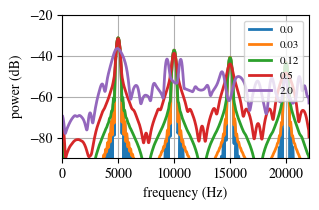

In [117]:
""" 
Figure 5 (Boyko & Canfield-Dafilou, 2024)
PSD for DSWS using a 5 kHz band-limited sawtooth
wavetable and stochastic pitch deviations according to a Bernoulli
probability distribution and variable pitch deviation amount
"""

fs = 44100
frequency = 5000

pitchDeviations = np.concatenate(([0], 2.0**np.arange(-5, 3,2)))

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for pd in pitchDeviations:
    testing = DSWS(waveFunc="BLSaw", length=3, frequency=frequency,
                   pitchStepBound=1, pitchStepSize=1, maxAmpDev=0.,
                   walkOrder=2, waveSegments=4, isSingleSegment=True,
                   probDistribution="drunk", pitchDepth=pd)
    x = testing.genAudio()
    # x, _ = dsws(samplerate=fs, length=0.5, maxAmplitudeDev=0, maxPitchDev=pd, \
    #        singleSegment=True, freq=frequency, waveSegments=4, waveFunc=genBLSaw, \
    #        pitchStepSize=6, pitchStepBound=24, constant=True, devMode="stochastic", \
    #        prob_dist="drunk", walkOrder=2)

    # balanced_x = x - np.mean(x)

    f, p = sig.welch(x, fs, nfft=2048)
    sf.write(f'Audio/fig5/saw_pitchdev_f{frequency}_{pd}.wav', x, fs)
    plt.plot(f,10*np.log10(p), linewidth=2, label=np.round(pd, 2))

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
# plt.savefig('NEW_saw_drunk_f' + str(frequency) + '.pdf')

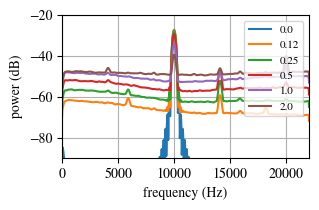

In [132]:
""" 
Figure 6 (Boyko & Canfield-Dafilou, 2024)
PSD for DSWS using a 10 kHz sinusoidal wavetable and
stochastic amplitude deviations with variable amplitude deviation amount
"""

fs = 44100
frequency = 10000

ampDeviations = np.concatenate(([0], 2.0**np.arange(-3, 2)))

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for ad in ampDeviations:
    testing = DSWS(waveFunc="sine", length=3, frequency=frequency,
                   pitchStepBound=1, pitchStepSize=1, maxAmpDev=ad,
                   walkOrder=2, waveSegments=4, isSingleSegment=False,
                   probDistribution="cauchy", pitchDepth=0)
    x = testing.genAudio()

    f, p = sig.welch(x, fs, nfft=2048)
    # sf.write(f'Audio/fig6/sine_ampdev_f{frequency}_{ad}.wav', x, fs)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label=np.round(ad, 2))

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('NEW_ampdev_f' + str(frequency) + '.pdf')

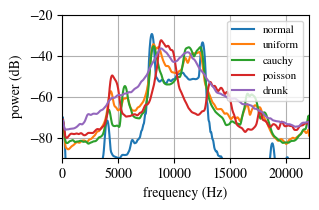

In [108]:
""" 
Figure 7 (Boyko & Canfield-Dafilou, 2024)
PSD for DSWS using a 10 kHz sinusoidal wavetable and
stochastic pitch deviations according to each probability 
distribution, with a maximum deviation of one semitone
"""

fs = 44100
frequency = 10000

prob_dists = ["normal", "uniform", "cauchy", "poisson", "drunk"]

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for pdist in prob_dists:
    testing = DSWS(waveFunc="sine", length=1, frequency=frequency,
                   pitchStepBound=24, pitchStepSize=6, maxAmpDev=0,
                   walkOrder=2, waveSegments=4, isSingleSegment=True,
                   probDistribution=pdist, pitchDepth=1/6)
    x = testing.genAudio()
    
    bal_x = x - np.mean(x)

    f, p = sig.welch(bal_x, fs, nfft=2048)
    # sf.write(f'Audio/fig7/sine_pitchdev_f{frequency}_{pdist}.wav', x, fs)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label=pdist)

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
display(Audio(data=(x), rate=fs))
plt.savefig('NEW_pdists_singleseg_f' + str(frequency) + '.pdf')

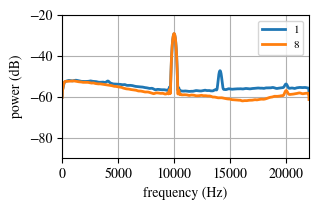

In [219]:
# no pitch deviation, 0.5 amp deviation.
# naive oversampling test to reduce aliasing issues

fs = 44100
frequency = 10000
oversamples = [1,8]

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

for os in oversamples:
    testing = DSWS(waveFunc="sine", length=3, frequency=frequency, fs=fs,
                       pitchStepBound=24, pitchStepSize=6, maxAmpDev=0.5,
                       walkOrder=1, waveSegments=4, isSingleSegment=True,
                       probDistribution="uniform", pitchDepth=0, oversample=os)
    test_output = testing.genAudio()

    f, p = sig.welch(test_output, fs, nfft=2048)
    plt.plot(f,10*np.log10(p), linewidth=2, label=f"{os}")

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('oversample_8x_amp_f' + str(frequency) + '.pdf')

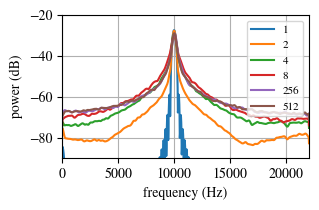

In [426]:
# plot power spectral density as a function of number of wavetable segments, sine wavetable

fs = 44100
frequency = 10000

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

numSegs = [1, 2, 4, 8, 256, 512]

for ns in numSegs:
    x, _ = dsws(samplerate=fs, length=0.5, maxAmplitudeDev=0, maxPitchDev=0.1, \
           singleSegment=False, freq=frequency, waveSegments=int(ns), waveFunc=np.sin, \
           pitchStepSize=6, pitchStepBound=24, constant=True, devMode="stochastic")
    f, p = sig.welch(x, fs, nfft=2048)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label=np.round(ns, 2))

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('numsegs_f' + str(frequency) + '.pdf')

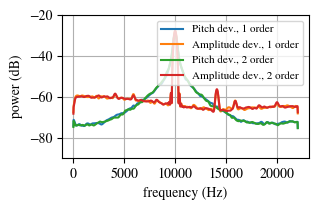

In [371]:
# plot power spectral density as a function of random walk order, sine wavetable

fs = 44100
frequency = 10000

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

order = [1, 2]

for o in order:
    pitch, _ = dsws(samplerate=fs, length=0.5, maxAmplitudeDev=0, maxPitchDev=0.1, \
           singleSegment=False, freq=frequency, waveSegments=4, waveFunc=np.sin, \
           pitchStepSize=6, pitchStepBound=24, constant=True, devMode="stochastic", walkOrder=o)
    f, p = sig.welch(pitch, fs, nfft=2048)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label='Pitch dev., ' + str(o) + ' order')
    
    amp, _ = dsws(samplerate=fs, length=0.5, maxAmplitudeDev=0.5, maxPitchDev=0, \
           singleSegment=False, freq=frequency, waveSegments=4, waveFunc=np.sin, \
           pitchStepSize=6, pitchStepBound=24, constant=True, devMode="stochastic", walkOrder=o)
    f, p = sig.welch(amp, fs, nfft=2048)
    plt.plot(f,10*np.log10(p), linewidth=1.5, label='Amplitude dev., ' + str(o) + ' order')

plt.grid()
plt.ylim(-90, -20)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
plt.savefig('walkOrder_f' + str(frequency) + '.pdf')

(132300,)


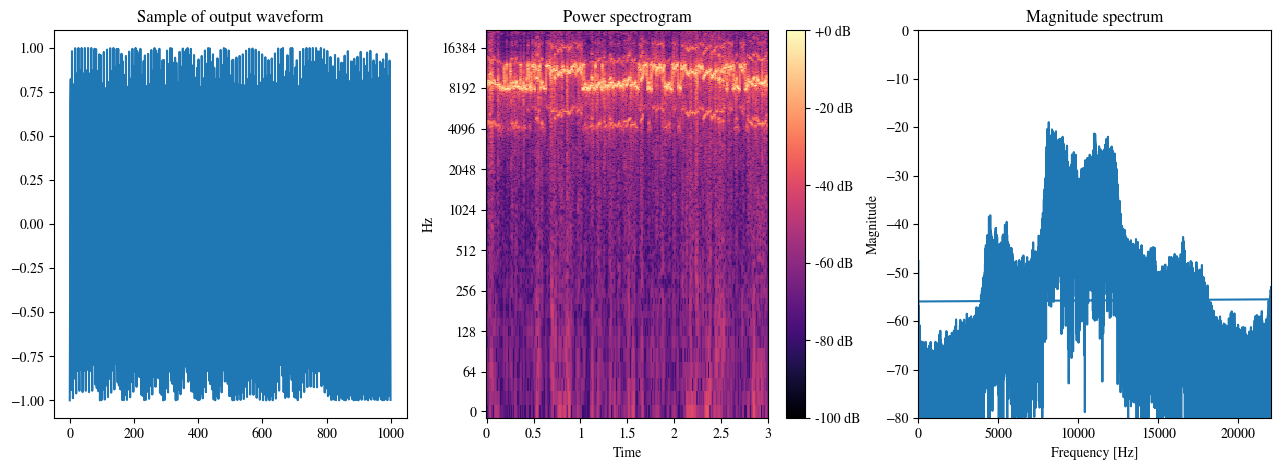

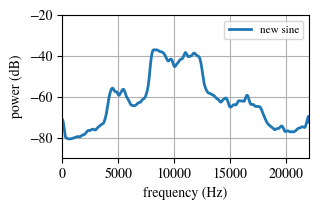

In [107]:
# only pitch deviation, no amp deviation. try changing pitchStepBound, pitchStepSize, and walkOrder (in {1, 2})
fs = 44100
frequency = 10000

testing = DSWS(waveFunc="sine", frequency=frequency, pitchStepBound=4, pitchStepSize=0.1, maxAmpDev=0, walkOrder=2, waveSegments=1)
test_output = testing.genAudio()
display(Audio(data=(test_output), rate=testing.fs))
testing.plotInfo()

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

f, p = sig.welch(test_output, fs, nfft=2048)
# sf.write(f'Audio/fig5/saw_pitchdev_f{frequency}_{pd}.wav', x, fs)
plt.plot(f,10*np.log10(p), linewidth=2, label="new sine")

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
# plt.savefig('saw_drunk_f' + str(frequency) + '.pdf')

(132300,)


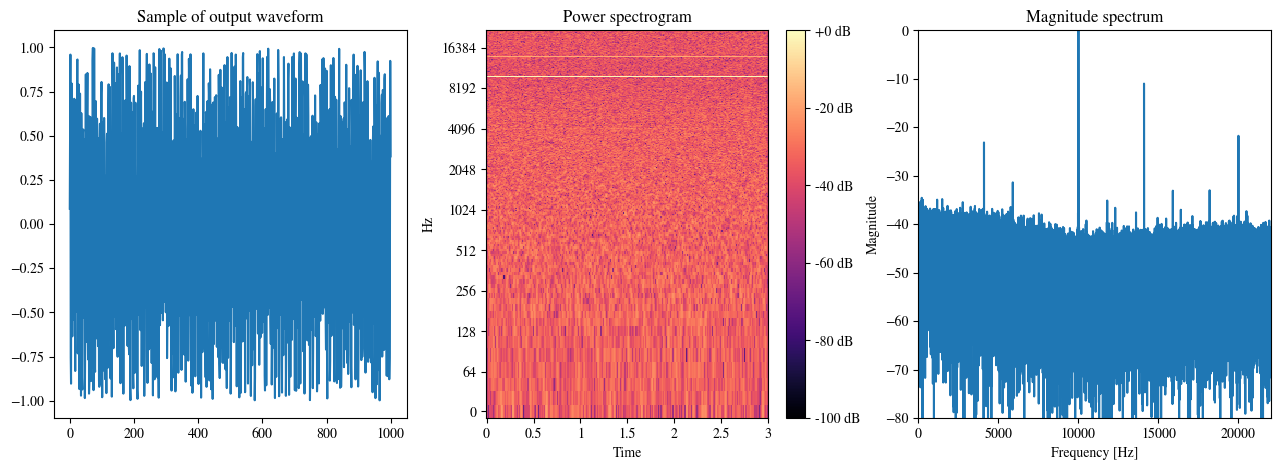

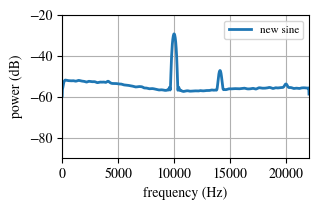

In [102]:
""" 
Figure 2 (Boyko & Canfield-Dafilou, 2024)
PSD for DSWS using a 10 kHz sinusoidal wavetable
and stochastic pitch deviations according to a Bernoulli 
probability distribution and variable pitch deviation amount
"""

fs = 44100
frequency = 10000

testing = DSWS(waveFunc="sine", length=3, frequency=frequency,
                   pitchStepBound=24, pitchStepSize=6, maxAmpDev=0.5,
                   walkOrder=1, waveSegments=4, isSingleSegment=True,
                   probDistribution="uniform", pitchDepth=0, oversample=1)
test_output = testing.genAudio()
display(Audio(data=(test_output), rate=testing.fs))
testing.plotInfo()

plt.rcParams.update({'font.size': 10})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.figure(figsize=(3.29, 2.2))

f, p = sig.welch(test_output, fs, nfft=2048)
# sf.write(f'Audio/fig5/saw_pitchdev_f{frequency}_{pd}.wav', x, fs)
plt.plot(f,10*np.log10(p), linewidth=2, label="new sine")

plt.grid()
plt.ylim(-90, -20)
plt.xlim(0, fs/2)
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)')
# plt.title('LFO (constant) pitch deviation @ 500Hz')
plt.legend(loc='upper right', prop={'size': 8})
plt.tight_layout()
# plt.savefig('saw_drunk_f' + str(frequency) + '.pdf')